Importing Required Libraries

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

The build_qgb function sets up the quantum circuit for a given number of levels.

Levels (L) define how many rows of pegs the “ball” will traverse.

Position Qubits represent possible positions along the board.

Ancilla Qubit acts as a temporary control for each swap.

Classical Bits store measurement results for the bin positions of interest.

Circuit Flow:

Initialize the ball at the center position.

For each level:

Reset and prepare the ancilla qubit in superposition (Hadamard gate).

Sequentially perform controlled swaps to move the ball left or right.


Measure only the position qubits that correspond to final bin locations.
This produces a quantum version of the Galton Board experiment.



In [2]:

def build_qgb(n_levels: int) -> QuantumCircuit:
    
    L = n_levels
    n_pos = 2 * L + 1            
    center = L                   

    
    ancilla = QuantumRegister(1, "ancilla")        
    qubit_pos  = QuantumRegister(n_pos, "qubit_pos")     
    bin_indices = [i for i in range(n_pos) if (i - center) % 2 == 0]  
    creg = ClassicalRegister(len(bin_indices), "c")

    qc = QuantumCircuit(ancilla, qubit_pos, creg)

    
    qc.x(qubit_pos[center])

   
    for level in range(L):
        
        qc.reset(ancilla[0])
        qc.h(ancilla[0])

        
        start = center - (level + 1)
        end   = center + level
        for j in range(start, end + 1):
            
            qc.append(CSwapGate(), [ancilla[0], qubit_pos[j], qubit_pos[j + 1]])

            
            qc.cx(qubit_pos[j + 1], ancilla[0])

    
    for k, i in enumerate(bin_indices):
        qc.measure(qubit_pos[i], creg[k])

    return qc, bin_indices




The post_process_bins function converts raw quantum measurement results into a histogram of final bin counts.

It looks for outcomes where exactly one “ball” qubit is in state |1⟩ (meaning the ball ended up in that position).

Counts are aggregated for each bin index, producing a clearer representation of the simulation’s outcome distribution.

In [3]:
def post_process_bins(counts, n_levels, bin_indices):
    
    L = n_levels
    bin_counts = Counter()
    for bitstring, c in counts.items():
        
        bits = bitstring[::-1]
        if bits.count('1') == 1:
            b = bits.index('1')
            bin_counts[b] += c
    return dict(bin_counts)



The run_qgb function is the main execution wrapper for the quantum Galton Board:

Builds the QGB circuit for a specified number of levels.

Optionally displays the full circuit diagram.

Transpiles the circuit for the AerSimulator backend.

Runs the simulation for a given number of shots.

Processes raw counts into bin counts using post_process_bins.

Plots a histogram of final bin positions.
The printed and plotted results give a visual probability distribution of where the ball is most likely to land.

Processed (bin-index) counts: {0: 4, 8: 4, 4: 265, 1: 26, 7: 46, 5: 232, 3: 211, 6: 95, 2: 141}


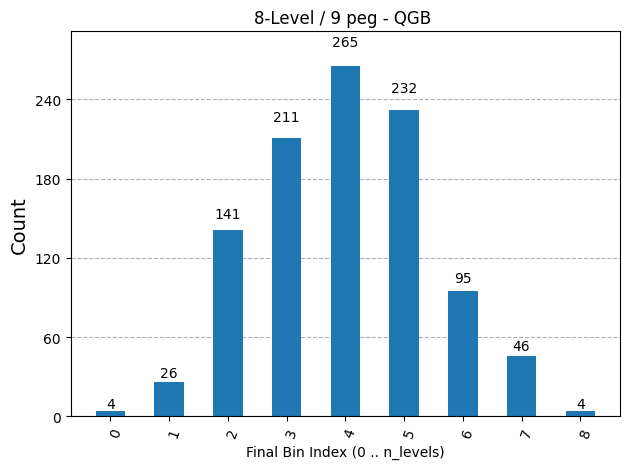

In [5]:
def run_qgb(n_levels=8, shots=1024, draw=False):
    qc, bin_indices = build_qgb(n_levels)
    if draw:
        display(qc.draw("mpl"))

    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    bin_counts = post_process_bins(counts, n_levels, bin_indices)
    print("Processed (bin-index) counts:", bin_counts)

    
    labeled = {str(k): v for k, v in sorted(bin_counts.items())}
    plot_histogram(labeled, sort='asc')
    plt.title(f"{n_levels}-Level / {n_levels+1} peg - QGB ")
    plt.xlabel("Final Bin Index (0 .. n_levels)")
    plt.tight_layout()
    plt.show()

    return qc, counts, bin_counts


if __name__ == "__main__":
    qc, counts, bin_counts = run_qgb(n_levels= 8, shots = 1024, draw=False)